In [45]:
!ls ../experiments/logs

max_depth_20	max_rhs_len_20	     num_nonterminals_20  num_terminals_80
max_depth_40	max_rules_per_nt_10  num_nonterminals_40  template
max_rhs_len_10	max_rules_per_nt_20  num_terminals_40


In [46]:
import glob
import os
import pandas as pd
import plotnine as p9

In [47]:
dfs = []
for file in glob.glob("../experiments/logs/**/SummaryEvaluator.csv") + glob.glob("../experiments/logs_4_1_128/**/SummaryEvaluator.csv"):
    print(file)
    evaluator = file.split("/")[-1].split(".")[0]
    splitted = os.path.dirname(file).split("/")[-1].split(".")[0].split("_")
    ablation = "_".join(splitted[:-1]) if len(splitted) > 1 else "template"
    ablation_val = int(splitted[-1]) if len(splitted) > 1 else 0
    log = pd.read_csv(file)
    print(len(log))
    log["identifier"] = file
    log["ablation"] = ablation
    log["ablation_val"] = ablation_val  
    log["evaluator"] = evaluator
    log["step_rel"] = log["step"] / log["step"].max()
    log["layers"] = "4" if "128" in file else "2"
    log = log.groupby(["variable", "step", "evaluator", "step_rel", "identifier", "ablation", "ablation_val", "layers"]).mean().reset_index()
    dfs.append(log)
print(len(dfs))
df = pd.concat(dfs)
df = df.groupby(["variable", "step", "evaluator", "step_rel", "identifier", "ablation", "ablation_val", "layers"]).mean().reset_index()
df

../experiments/logs/num_terminals_40/SummaryEvaluator.csv
258661
../experiments/logs/max_rules_per_nt_10/SummaryEvaluator.csv
258661
../experiments/logs/max_depth_20/SummaryEvaluator.csv
258661
../experiments/logs/max_depth_40/SummaryEvaluator.csv
258661
../experiments/logs/template/SummaryEvaluator.csv
258661
../experiments/logs/max_rhs_len_10/SummaryEvaluator.csv
258661
../experiments/logs/max_rhs_len_20/SummaryEvaluator.csv
258661
../experiments/logs/num_nonterminals_20/SummaryEvaluator.csv
258661
../experiments/logs/max_rules_per_nt_20/SummaryEvaluator.csv
258661
../experiments/logs/num_terminals_80/SummaryEvaluator.csv
258661
../experiments/logs/num_nonterminals_40/SummaryEvaluator.csv
258661
../experiments/logs_4_1_128/max_rules_per_nt_10/SummaryEvaluator.csv
258661
../experiments/logs_4_1_128/template/SummaryEvaluator.csv
258661
../experiments/logs_4_1_128/max_depth_40/SummaryEvaluator.csv
258661
../experiments/logs_4_1_128/max_rhs_len_10/SummaryEvaluator.csv
258661
../experimen

,variable,step,evaluator,step_rel,identifier,ablation,ablation_val,layers,value
0,PARENT.query_item.kl_div,0,SummaryEvaluator,0.0,../experiments/logs/max_depth_20/SummaryEvalua...,max_depth,20,2,3.360136
1,PARENT.query_item.kl_div,0,SummaryEvaluator,0.0,../experiments/logs/max_depth_40/SummaryEvalua...,max_depth,40,2,3.343890
2,PARENT.query_item.kl_div,0,SummaryEvaluator,0.0,../experiments/logs/max_rhs_len_10/SummaryEval...,max_rhs_len,10,2,3.306045
3,PARENT.query_item.kl_div,0,SummaryEvaluator,0.0,../experiments/logs/max_rhs_len_20/SummaryEval...,max_rhs_len,20,2,3.323542
4,PARENT.query_item.kl_div,0,SummaryEvaluator,0.0,../experiments/logs/max_rules_per_nt_10/Summar...,max_rules_per_nt,10,2,3.330249
...,...,...,...,...,...,...,...,...,...
11105,query_item.pred_prob,20000,SummaryEvaluator,1.0,../experiments/logs_4_1_128/num_nonterminals_2...,num_nonterminals,20,4,0.825627
11106,query_item.pred_prob,20000,SummaryEvaluator,1.0,../experiments/logs_4_1_128/num_nonterminals_4...,num_nonterminals,40,4,0.596040
11107,query_item.pred_prob,20000,SummaryEvaluator,1.0,../experiments/logs_4_1_128/num_terminals_40/S...,num_terminals,40,4,0.992447
11108,query_item.pred_prob,20000,SummaryEvaluator,1.0,../experiments/logs_4_1_128/num_terminals_80/S...,num_terminals,80,4,0.997648


/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


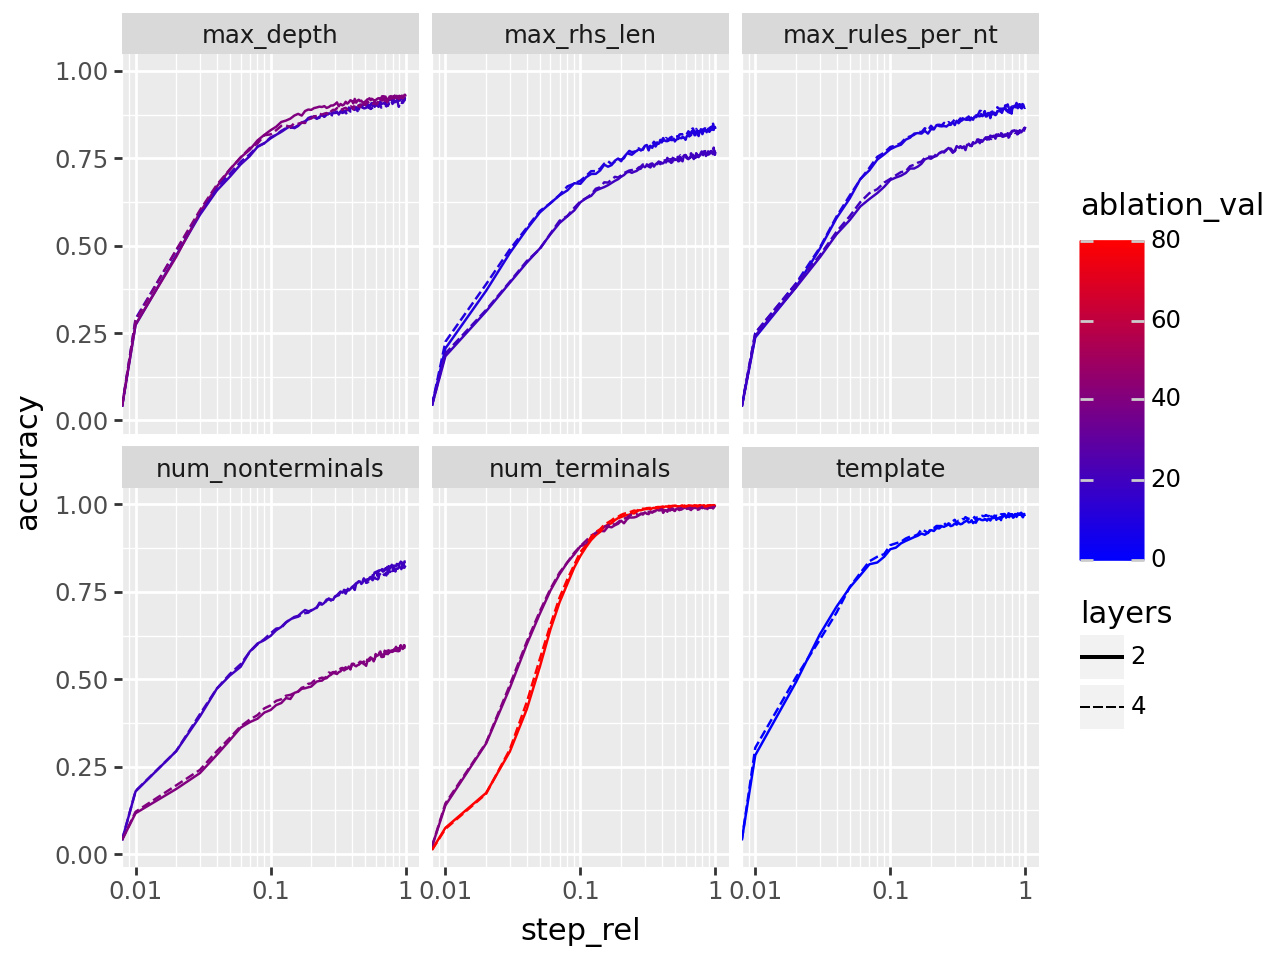

In [48]:
subset_df = df[df["variable"] == "query_item.pred_prob"]
plot = (
    p9.ggplot(subset_df, p9.aes(x="step_rel", y="value", color="ablation_val", group="identifier", linetype="layers")) +
    p9.geom_line() +
    p9.facet_wrap("~ ablation") +
    p9.scale_x_log10() +
    p9.scale_color_gradient(low="blue", high="red") +
    p9.labs(y="accuracy")
)
plot.show()